Assignment:4
1. You have to create one supervisor node.
2. create one router function
3. create three more node 
   3.1 llm call (llm node)
   3.2 RAG (rag node)
   3.3 web crawler(fetch the info in realtime from internet)
4. created one more node after this for validation for generated output --> explore the validation part how to do that
5. if validation going to be failed in that case again go to supervioser node and then supervisor node will again decide what needs to be call next
6. once the validation will pass then only generate the final output

### Configure the model

In [2]:
# Loading the model
from langchain_google_genai import ChatGoogleGenerativeAI
model = ChatGoogleGenerativeAI(model='gemini-1.5-flash')
output = model.invoke("Hi")
output

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run--50d3f3f4-7dbe-4689-a30f-32d97b5cf4bd-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

### Configure the Embedding Model

In [3]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name = "BAAI/bge-small-en")
len(embeddings.embed_query("hi"))

/Users/ankita/Documents/Krish Naik Academy/Agentic Batch 2/Langraph/langraph_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


384

### Load the data and embed the document

In [4]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

FILE_PATH = "/Users/ankita/Documents/Krish Naik Academy/Agentic Batch 2/Langraph/data/science.pdf"  # Change this to your PDF path
loader = PyPDFLoader(FILE_PATH)
docs = loader.load()

In [5]:
docs

[Document(metadata={'producer': 'iLovePDF', 'creator': 'PyPDF', 'creationdate': '', 'moddate': '2025-06-13T05:37:33+00:00', 'source': '/Users/ankita/Documents/Krish Naik Academy/Agentic Batch 2/Langraph/data/science.pdf', 'total_pages': 272, 'page': 0, 'page_label': '1'}, page_content='Textbook of Science for Grade 6\nCuriosity\n0 Prelims.indd   1 23/12/2024   16:06:53\nReprint 2025-26'),
 Document(metadata={'producer': 'iLovePDF', 'creator': 'PyPDF', 'creationdate': '', 'moddate': '2025-06-13T05:37:33+00:00', 'source': '/Users/ankita/Documents/Krish Naik Academy/Agentic Batch 2/Langraph/data/science.pdf', 'total_pages': 272, 'page': 1, 'page_label': '2'}, page_content='First Edition\nJuly 2024 Jyeshtha 1946\nReprint\nDecember 2024 Pausha 1946\nPD 2200T GS\n© National Council of Educational \nResearch and Training, 2024\n 65.00\nPrinted on 80 GSM paper with NCERT \nwatermark\nPublished at the Publication Division \nby the Secretary, National Council of \nEducational Research and Traini

In [6]:
text_splitter=RecursiveCharacterTextSplitter(chunk_size=800,chunk_overlap=50)
new_docs = text_splitter.split_documents(docs)
new_docs

db=Chroma.from_documents(new_docs,embeddings)
retriever=db.as_retriever(search_kwargs={"k": 3})

/Users/ankita/Documents/Krish Naik Academy/Agentic Batch 2/Langraph/langraph_venv/lib/python3.11/site-packages/opentelemetry/proto/collector/trace/v1/trace_service_pb2_grpc.py:26: RuntimeWarning: The grpc package installed is at version 1.58.0, but the generated code in opentelemetry/proto/collector/trace/v1/trace_service_pb2_grpc.py depends on grpcio>=1.63.2. Please upgrade your grpc module to grpcio>=1.63.2 or downgrade your generated code using grpcio-tools<=1.58.0. This warning will become an error in 1.65.0, scheduled for release on June 25, 2024.
  warnings.warn(


In [15]:
retriever.invoke("industrial growth of usa?")

[Document(metadata={'creator': 'PyPDF', 'creationdate': '', 'page': 165, 'source': '/Users/ankita/Documents/Krish Naik Academy/Agentic Batch 2/Langraph/data/science.pdf', 'total_pages': 272, 'producer': 'iLovePDF', 'page_label': '166', 'moddate': '2025-06-13T05:37:33+00:00'}, page_content='the digital weighing balance. Will it increase or decrease or \nremain the same? \nDew drops on plants\nChapter 8.indd   148 10/4/2024   3:12:01 PM\nReprint 2025-26'),
 Document(metadata={'source': '/Users/ankita/Documents/Krish Naik Academy/Agentic Batch 2/Langraph/data/science.pdf', 'page_label': '127', 'total_pages': 272, 'producer': 'iLovePDF', 'creationdate': '', 'creator': 'PyPDF', 'moddate': '2025-06-13T05:37:33+00:00', 'page': 126}, page_content='Wooden board\n Window glass\nMaterials Around Us\nChapter 6.indd   109 10/4/2024   3:15:28 PM\nReprint 2025-26'),
 Document(metadata={'creator': 'PyPDF', 'moddate': '2025-06-13T05:37:33+00:00', 'total_pages': 272, 'creationdate': '', 'source': '/User

### Creating Agent

In [16]:
import operator
from pydantic import BaseModel,Field
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage

#class AgentState(TypedDict):
    #question_from_user: Annotated[Sequence[BaseMessage], operator.add]

In [17]:
# Define Pydantic Schema (Only Topic)
from pydantic import BaseModel, Field

class ScienceTopicParser(BaseModel):
    Topic: str = Field(description="Is the topic related to science? (Science or Not Related)")


In [18]:
# Setup the Output Parser

from langchain.output_parsers import PydanticOutputParser

parser = PydanticOutputParser(pydantic_object=ScienceTopicParser)


In [19]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [56]:
#  Supervisor Node Function (Only Classifies Topic)
from langchain_core.prompts import PromptTemplate

def supervisor_node(state):
    question = state["messages"][-1]
    print("🧠 Supervisor received question:", question)

    template = """
    Your task is to classify the user query into one of the following categories: [Science, Not Related].
    Only return the category name in the format specified.

    User query: {question}

    {format_instructions}
    """

    prompt = PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )

    chain = prompt | model | parser
    response = chain.invoke({"question": question})

    print("🧭 Topic classified as:", response.Topic)

    return {"messages": [response.Topic]}


In [58]:
state = {"messages": ["What is science photosynthesis?"], "validated": False}


In [60]:
supervisor_node(state)
state

🧠 Supervisor received question: What is science photosynthesis?
🧭 Topic classified as: Science


{'messages': ['What is science photosynthesis?'], 'validated': False}

In [23]:
def router(state:AgentState):
    print("-> ROUTER ->")
    
    last_message=state["messages"][-1].lower()
    print("last_message:", last_message)
    
    if "science" in last_message:
        return "RAG Call"
    elif "current" in last_message or "latest" in last_message or "today" in last_message:
        return "WEB Call"
    else:
        return "LLM Call"

In [24]:
router(state)

-> ROUTER ->
last_message: what is science photosynthesis?


'RAG Call'

In [25]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [52]:
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

def rag_node(state: AgentState):
    print("🔬 RAG Node (Science Bot) running")
    
    question = state["messages"][0]  # Get the latest question

    # Prompt template tailored for science questions
    prompt = PromptTemplate(
        template="""You are a science tutor for school kids.
Use the following context from a science textbook to answer the question. 
Keep your answer friendly, simple, and in 2-3 short sentences.

Question: {question}

Context:
{context}

Answer:""",
        input_variables=["context", "question"]
    )

    # RAG pipeline: retrieve docs, build prompt, run model
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )

    result = rag_chain.invoke(question)

    return {"messages": [result]}


In [44]:
rag_node(state)

🔬 RAG Node (Science Bot) running


{'messages': ['Photosynthesis is how plants make their food!  They use sunlight, water, and air to create energy. This is why the sun is so important for life on Earth.']}

In [53]:
def llm_node(state: AgentState):
    print("🤖 LLM Node (Science Bot) running")
    
    question = state["messages"][0]  # Use the latest question from the state

    # Friendly and simple prompt
    complete_query = (
        "You are a friendly science tutor for kids. "
        "Answer the following question using your general science knowledge in 2-3 short, simple sentences. "
        f"Question: {question}"
    )

    response = model.invoke(complete_query)

    return {"messages": [response.content]}


In [29]:
llm_node(state)

🤖 LLM Node (Science Bot) running


{'messages': ['Photosynthesis is how plants make their food!  They use sunlight, water, and air to create sugary energy and release oxygen.']}

In [54]:
from tavily import TavilyClient
import os

# Initialize the Tavily API key securely
api_key = os.getenv("TAVILY_API_KEY")
tavily_client = TavilyClient(api_key=api_key)

# 🌐 WEB NODE for Science Bot
def web_node(state: dict) -> dict:
    print("🌐 -> Web Crawler (Tavily Search) Running")

    question = state["messages"][0]

    # Tavily Search
    response = tavily_client.search(
        query=question,
        search_depth="advanced",            # Use "basic" if you want it faster
        include_answer=True,
        include_raw_content=False
    )

    # Extract concise answer or fallback
    final_answer = response.get("answer", "Hmm... I couldn’t find the answer right now.")

    return {"messages": [final_answer]}


In [31]:
web_node(state)

🌐 -> Web Crawler (Tavily Search) Running


{'messages': ['Photosynthesis is a process plants use to convert light energy into chemical energy, producing oxygen and sugars. It uses sunlight, water, and carbon dioxide. This process is vital for life on Earth.']}

In [38]:
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
import operator

class AgentState(TypedDict):
    messages: Annotated[Sequence[str], operator.add]
    validated: bool


In [39]:
def validation_with_llm(state: AgentState):
    print("🧠 LLM-based Validation running...")
    
    prompt = f"""
You are a teacher evaluating answers for school children.

Check if this response meets all the following criteria:
- Relevant to the original science question
- Easy to understand for a 10-year-old
- Short (under 4 lines)

Response: "{state['messages'][-1]}"

Reply YES or NO only.
"""

    result = model.invoke(prompt).content.strip().lower()

    if "yes" in result:
        return {"validated": True, "messages": state["messages"]}
    else:
        return {"validated": False, "messages": state["messages"]}


In [40]:
from langgraph.graph import StateGraph, END

# Build the graph
builder = StateGraph(AgentState)

# 1. Entry point
builder.set_entry_point("Supervisor")

# 2. Add nodes
builder.add_node("Supervisor", supervisor_node)
builder.add_node("RAG Call", rag_node)
builder.add_node("LLM Call", llm_node)
builder.add_node("WEB Call", web_node)
builder.add_node("Validation", validation_with_llm)

# 3. Routing from supervisor to respective node
builder.add_conditional_edges("Supervisor", router, {
    "RAG Call": "RAG Call",
    "LLM Call": "LLM Call",
    "WEB Call": "WEB Call"
})

# 4. All three generation nodes go to Validation
builder.add_edge("RAG Call", "Validation")
builder.add_edge("LLM Call", "Validation")
builder.add_edge("WEB Call", "Validation")

# 5. Validation either ends or goes back to supervisor
builder.add_conditional_edges(
    "Validation",
    lambda state: "Final" if state["validated"] else "Supervisor",
    {
        "Final": END,
        "Supervisor": "Supervisor"
    }
)

# 6. Compile graph
science_bot_app = builder.compile()


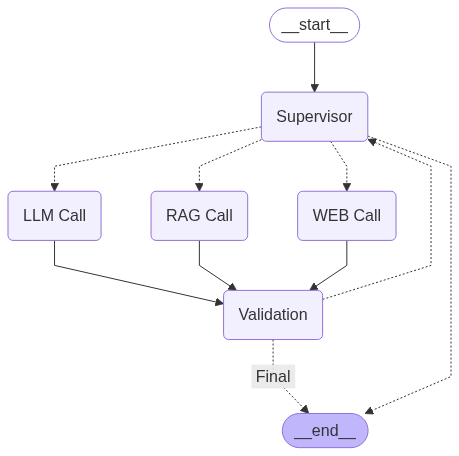

In [42]:
from IPython.display import Image, display
display(Image(science_bot_app .get_graph().draw_mermaid_png()))


In [55]:
# Initial question from user
state = AgentState(messages=["What is the photosynthesis?"], validated=False)

# Run the app
final_output = science_bot_app.invoke(state)
print("\n✅ Final Validated Answer:\n", final_output["messages"][-1])


🧠 Supervisor received question: What is the photosynthesis?
🧭 Topic classified as: Science
-> ROUTER ->
last_message: science
🔬 RAG Node (Science Bot) running
🧠 LLM-based Validation running...
🧠 Supervisor received question: That's a fun question!  This shows page numbers from a sixth-grade science textbook.  The book covers at least chapters 4 and 12, and was reprinted in 2025-2026.
🧭 Topic classified as: Science
-> ROUTER ->
last_message: science
🔬 RAG Node (Science Bot) running
🧠 LLM-based Validation running...
🧠 Supervisor received question: That's a fun question!  This information shows page numbers from a sixth-grade science textbook.  It looks like Chapter 4 starts on page 72 and Chapter 12 is on page 254.
🧭 Topic classified as: Science
-> ROUTER ->
last_message: science
🔬 RAG Node (Science Bot) running
🧠 LLM-based Validation running...

✅ Final Validated Answer:
 That's a fun question!  This information just shows the page numbers for different parts of your Grade 6 science tex

KeyError: 0

In [65]:
# === Setup ===
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain.output_parsers import PydanticOutputParser
from langgraph.graph import StateGraph, END

import operator, os
from typing import Annotated, Sequence, TypedDict
from pydantic import BaseModel, Field
from tavily import TavilyClient
from IPython.display import Image, display

# === Model and Embedding Setup ===
model = ChatGoogleGenerativeAI(model='gemini-1.5-flash')
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")

# === Load Data & Create Retriever ===
FILE_PATH = "/Users/ankita/Documents/Krish Naik Academy/Agentic Batch 2/Langraph/data/science.pdf"
loader = PyPDFLoader(FILE_PATH)
docs = loader.load()
splitter = RecursiveCharacterTextSplitter(chunk_size=800, chunk_overlap=50)
new_docs = splitter.split_documents(docs)
db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 3})

# === Define State ===
class AgentState(TypedDict):
    messages: Annotated[Sequence[str], operator.add]
    validated: bool

# === Parser for Supervisor ===
class ScienceTopicParser(BaseModel):
    Topic: str = Field(description="Is the topic related to science? (Science or Not Related)")

parser = PydanticOutputParser(pydantic_object=ScienceTopicParser)

# === Supervisor Node ===
def supervisor_node(state: AgentState) -> AgentState:
    question = state["messages"][-1]
    print("🧠 Supervisor received question:", question)

    template = """
    Your task is to classify the user query into one of the following categories: [Science, Not Related].
    Only return the category name in the format specified.

    User query: {question}

    {format_instructions}
    """

    prompt = PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )

    chain = prompt | model | parser
    response = chain.invoke({"question": question})

    print("🧭 Topic classified as:", response.Topic)
    return {"messages": state["messages"] + [response.Topic], "validated": False}

# === Router ===
def router(state: AgentState) -> str:
    print("-> ROUTER ->")
    last_message = state["messages"][-1].lower()
    print("last_message:", last_message)
    if "science" in last_message:
        return "RAG Call"
    elif "today" in last_message:
        return "WEB Call"
    else:
        return "LLM Call"

# === Helper Function ===
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# === RAG Node ===
def rag_node(state: AgentState) -> AgentState:
    print("🔬 RAG Node running")
    question = state["messages"][0]

    prompt = PromptTemplate(
        template="""You are a science tutor for school kids.
Use the following context from a science textbook to answer the question. 
Keep your answer friendly, simple, and in 2-3 short sentences.

Question: {question}

Context:
{context}

Answer:""",
        input_variables=["context", "question"]
    )

    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )

    result = rag_chain.invoke(question)
    return {"messages": state["messages"] + [result], "validated": False}

# === LLM Node ===
def llm_node(state: AgentState) -> AgentState:
    print("🤖 LLM Node running")
    question = state["messages"][0]

    query = (
        "You are a friendly science tutor for kids. "
        "Answer the following question using your general science knowledge in 2-3 short, simple sentences. "
        f"Question: {question}"
    )

    response = model.invoke(query)
    return {"messages": state["messages"] + [response.content], "validated": False}

# === Web Crawler Node ===
api_key = os.getenv("TAVILY_API_KEY")
tavily_client = TavilyClient(api_key=api_key)

def web_node(state: AgentState) -> AgentState:
    print("🌐 Web Node running")
    question = state["messages"][0]

    response = tavily_client.search(
        query=question,
        search_depth="advanced",
        include_answer=True,
        include_raw_content=False
    )

    final_answer = response.get("answer", "Hmm... I couldn’t find the answer right now.")
    return {"messages": state["messages"] + [final_answer], "validated": False}

# === Validation Node ===
def validation_with_llm(state: AgentState) -> AgentState:
    print("🧠 Validation running...")

    prompt = f"""
You are a teacher evaluating answers for school children.

Check if this response meets all the following criteria:
- Relevant to the original science question
- Easy to understand for a 10-year-old
- Short (under 4 lines)

Response: "{state['messages'][-1]}"

Reply YES or NO only.
"""

    result = model.invoke(prompt).content.strip().lower()
    is_valid = "yes" in result
    print("✅ Validation Result:", result)
    return {"messages": state["messages"], "validated": is_valid}

# === Build LangGraph ===
builder = StateGraph(AgentState)

builder.set_entry_point("Supervisor")
builder.add_node("Supervisor", supervisor_node)
builder.add_node("RAG Call", rag_node)
builder.add_node("LLM Call", llm_node)
builder.add_node("WEB Call", web_node)
builder.add_node("Validation", validation_with_llm)

builder.add_conditional_edges("Supervisor", router, {
    "RAG Call": "RAG Call",
    "LLM Call": "LLM Call",
    "WEB Call": "WEB Call"
})

builder.add_edge("RAG Call", "Validation")
builder.add_edge("LLM Call", "Validation")
builder.add_edge("WEB Call", "Validation")

builder.add_conditional_edges("Validation",
    lambda state: "Final" if state["validated"] else "Supervisor",
    {
        "Final": END,
        "Supervisor": "Supervisor"
    }
)

science_bot_app = builder.compile()

# Optional visualization
# display(Image(science_bot_app.get_graph().draw_mermaid_png()))

# === Run the Graph ===
initial_state = AgentState(messages=["What is photosynthesis?"], validated=False)
final_output = science_bot_app.invoke(initial_state)

print("\n✅ Final Validated Answer:\n", final_output["messages"][-1])


🧠 Supervisor received question: What is photosynthesis?
🧭 Topic classified as: Science
-> ROUTER ->
last_message: science
🔬 RAG Node running
🧠 Validation running...
✅ Validation Result: yes

✅ Final Validated Answer:
 Photosynthesis is how plants make their food!  They use energy from the sun to turn water and air into food. This is why the sun is so important for life on Earth.


In [1]:
initial_state = AgentState(messages=["What is Vancouver?"], validated=False)
final_output = science_bot_app.invoke(initial_state)

print("\n✅ Final Validated Answer:\n", final_output["messages"][-1])


NameError: name 'AgentState' is not defined